In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import diff_classifier.heatmaps as hm

import os
import os.path as op

In [31]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    counter = 0
    for p1, region in enumerate(vor.point_region):
        try:
            vertices = vor.regions[region]

            if all(v >= 0 for v in vertices):
                # finite region
                new_regions.append(vertices)
                continue

            # reconstruct a non-finite region
            ridges = all_ridges[p1]
            new_region = [v for v in vertices if v >= 0]

            for p2, v1, v2 in ridges:
                if v2 < 0:
                    v1, v2 = v2, v1
                if v1 >= 0:
                    # finite ridge: already in the region
                    continue

                # Compute the missing endpoint of an infinite ridge

                t = vor.points[p2] - vor.points[p1] # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal

                midpoint = vor.points[[p1, p2]].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + direction * radius

                new_region.append(len(new_vertices))
                new_vertices.append(far_point.tolist())

            # sort region counterclockwise
            vs = np.asarray([new_vertices[v] for v in new_region])
            c = vs.mean(axis=0)
            angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
            new_region = np.array(new_region)[np.argsort(angles)]

            # finish
            new_regions.append(new_region.tolist())
        except KeyError:
            counter = counter + 1
            #print('Oops {}'.format(counter))

    return new_regions, np.asarray(new_vertices)

In [8]:
# # make up data points
# np.random.seed(1234)
# points = np.random.rand(15, 2)

remote_folder = "01_18_Experiment/P1"
local_folder = os.getcwd()
ires = 512
prefix = 'P1_S1_L_0012'
frames = 651

merged_ft = pd.read_csv('features_{}.csv'.format(prefix))

In [16]:
points = np.zeros((merged_ft['X'].as_matrix().shape[0], 2))
points[:, 0] = merged_ft['X'].as_matrix()
points[:, 1] = merged_ft['Y'].as_matrix()

In [32]:
%matplotlib inline

--
[[176, 72, 67, 66, 65, 175], [23095, 15907, 10306, 10307, 3450, 3449, 21, 20, 1651, 9529, 9530, 5706, 3148, 3455, 3454, 23094], [48906, 30357, 30356, 5736, 5738, 9571, 48905], [362, 6, 3, 164, 361], [5783, 3196, 1677, 1676, 1678, 1685, 1684, 5782], [9550, 9546, 5715, 9544, 9542, 9549], [5742, 3182, 825, 169, 807, 808, 374, 5741], [1678, 831, 7, 4, 1676], [172, 66, 65, 18, 16, 15, 171], [41494, 15995, 15031, 23166, 23167, 41491], [834, 389, 173, 63, 64, 833], [30487, 21938, 21939, 15018, 3183, 5765, 22052, 30483], [165, 61, 14, 3, 164], [41455, 15959, 15960, 15964, 31908, 41453], [50678, 23169, 23167, 23166, 23171, 23170, 31944, 31943, 23168, 50677], [22048, 5753, 361, 362, 830, 22047], [394, 14, 3, 6, 5, 22, 23, 75, 390], [59112, 50661, 31924, 39695, 39696, 30418, 23165, 41496, 59111], [22113, 6215, 15977, 15976, 15126, 22112], [30355, 21893, 15009, 15011, 9616, 30354], [386, 171, 172, 384], [15998, 15035, 15036, 9645, 15028, 15027, 9644, 15996], [30398, 21941, 30392, 30391, 9623, 9

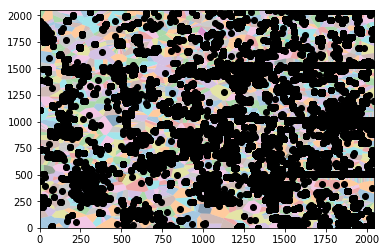

In [33]:
# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print "--"
print regions
print "--"
print vertices

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

#plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.show()

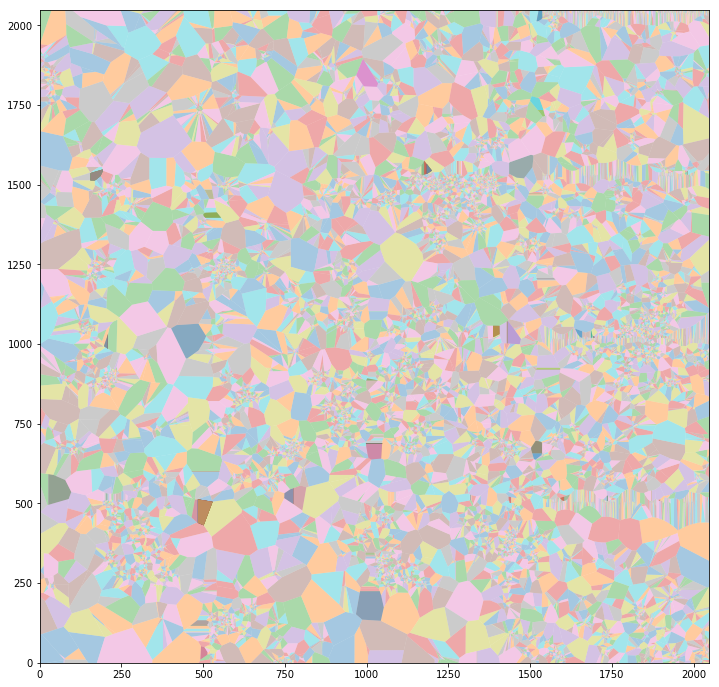

In [34]:
plt.figure(figsize = (12, 12))
# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

#plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.show()

In [ ]:
plt.fill

In [36]:
*polygon

SyntaxError: invalid syntax (<ipython-input-36-fa26eef12909>, line 1)

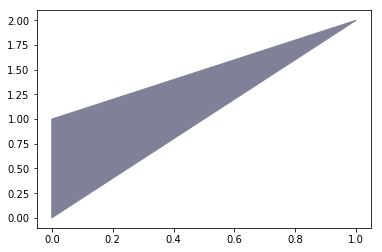

In [45]:
xs = [0, 0, 1]
ys = [0, 1, 2]
colors=[(0.1, 0.2, 0.1)]

plt.fill(xs, ys, color=(0.5, 0.5, 0.6))